This module will process all the projects data and serve as a hub for team building. 
Algorithm flow:
1. Preprocess all project-related text
2. Create an project embedding matrix for all the matrix
3. Use cosine similarity score for ranking top related projects
4. Pull people worked in the top K projects, return a list of people (eId)
5. If there is not enough people, tab into people's similarity matrix for more people. **

In [409]:
import pandas as pd
import psycopg2
import matplotlib
import matplotlib.pyplot as plt
import re
import numpy as np
import nltk
import pickle
import seaborn as sns
from autocorrect import spell
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn import preprocessing
from nltk.stem import SnowballStemmer
from functools import reduce
from sklearn.metrics.pairwise import cosine_similarity
sns.set(style="white")

plt.rcParams["figure.figsize"] = (10,8)

nltk.download('punkt', 'stopwords')

[nltk_data] Downloading package punkt to stopwords...
[nltk_data]   Package punkt is already up-to-date!


True

# 1. Data processing

## 1.1 Load the data

In [620]:
employee = pd.read_csv('../data/employee_M25.txt',sep = '|',index_col = 'ID')
project = pd.read_csv('../data/project_M25_matched.txt',sep = '|', index_col = 'pID')
projectCategory = pd.read_csv('../data/Project_category_M23.txt',sep = '|')

In [621]:
print("Shape of employee table is (%d,%d)"%employee.shape)
print("Shape of project table is (%d,%d)"%project.shape)
print("Project categoryes is %s"%projectCategory.values)

Shape of employee table is (198,10)
Shape of project table is (594,5)
Project categoryes is [[1 'Business']
 [2 'Legal']
 [3 'Exam']
 [4 'Technology']
 [5 'Finacial']]


In [622]:
# save employee name -> ID dictionary
employee['fullname'] = employee['FirstName'].str.strip() + " " + employee['LastName'].str.strip()
name2IdDict = dict(zip(employee['fullname'].values, employee.index.values))
with open("employeNameIDDict.pkl",'wb') as infile:
    pickle.dump(name2IdDict,infile)

In [623]:
employee.head()

,profilePictrueName,FirstName,LastName,Degree,YeasInCompany,Skills,PastProjectsID,Hobbies,ManagerId,Hub,fullname
ID,,,,,,,,,,,
12126,BrantCrichlow,Brant,Crichlow,MS,2,"Marketing, sales and customer service",1;89;154,Travel,12126,Business,Brant Crichlow
12069,JohnChevez,John,Chevez,MS,3,"Time management, Client server",2;88;153,Swimming,12069,Business,John Chevez
12070,JustinKapadia,Justin,Kapadia,MS,3,Configuration Mgt,3;91;152,Travel,12070,Business,Justin Kapadia
12072,DouglasGiarratano,Douglas,Giarratano,MS,3,Release Management,4;90;151,Basketball,12072,Business,Douglas Giarratano
12103,GeraldOtto,Gerald,Otto,MS,7,Enterprise Alerts,5;93;150,Reading,12103,Business,Gerald Otto


In [624]:
employeeBaseInf = employee[['FirstName','LastName','profilePictrueName']]

In [625]:
project.head()

,ProjectName,ProjectTeam,ProjectOwner,ProjectDescription,ProjectCategoryId
pID,,,,,
1,Planning,12126,Alesha Pasternak,"Workforce and Financial planning, reporting an...",1
2,slutions meeting,12069,Sung Mijangos,"Tax, Payment and Compliance Solution meeting",1
3,Travel planning,12070,Phyliss Barrette,Travel Management is a provider of travel man...,1
4,Risk monitoring,12072,Suk Bunn,firm review using analytics workspace,1
5,Registration,12103,Eliz Dewall,reporting of registration statistics,1


## 1.2 preprocess the data
There are two data tables to be processed: 1. employee table 2. Project table

In [626]:
col2use = ['Degree','YeasInCompany','Skills','PastProjectsID','Hobbies','Hub']

In [627]:
employee.columns

Index(['profilePictrueName', 'FirstName', 'LastName', 'Degree',
       'YeasInCompany', 'Skills', 'PastProjectsID', 'Hobbies', 'ManagerId',
       'Hub', 'fullname'],
      dtype='object')

In [628]:
# catFeatures = ['Degree','YeasInCompany','Hobbies','Hub']
# for feat in catFeatures:
#     employee[feat] = employee[feat].astype('category')
# employee[catFeatures] = employee[catFeatures].apply(lambda x: x.cat.codes)
# employee.head()

In [629]:
## Convert categorical features to one hot encoding
catFeatures = ['Degree','YeasInCompany','Hobbies','Hub']
emplyeeCatFeaturesWithoutSkillsProjects = pd.get_dummies(employee[catFeatures], prefix_sep = '_', drop_first=True)
emplyeeCatFeaturesWithoutSkillsProjects.head()

,YeasInCompany,Hobbies_Bike,Hobbies_Hiking,Hobbies_Reading,Hobbies_Swimming,Hobbies_Travel,Hobbies_Volleyball,Hub_Exam,Hub_Fiancial,Hub_Finacial,Hub_Legal,Hub_Technology
ID,,,,,,,,,,,,
12126,2,0,0,0,0,1,0,0,0,0,0,0
12069,3,0,0,0,1,0,0,0,0,0,0,0
12070,3,0,0,0,0,1,0,0,0,0,0,0
12072,3,0,0,0,0,0,0,0,0,0,0,0
12103,7,0,0,1,0,0,0,0,0,0,0,0


In [630]:
# massage employee skill data
employee['ID'] = employee.index
emplyeeSkillsdata = pd.melt(employee[['ID','Skills']].set_index('ID')['Skills'].str.split(",", n = -1, expand = True).reset_index(),
              id_vars = ['ID'],
              value_name = 'Skills')\
        .dropna().drop(['variable'], axis = 1)\
        .groupby(['ID','Skills']).agg({'Skills':"count"})\
        .rename(columns={'Skills':'SkillsCount'}).reset_index()
emplyeeSkillsdata['SkillsCount'] = emplyeeSkillsdata['SkillsCount'].astype(np.int64)

In [631]:
emplyeeSkillsdata.head()

,ID,Skills,SkillsCount
0,12056,Business finance and loans,1
1,12056,Developing financial processes and procedures,1
2,12057,Budgets and forecasts,1
3,12058,Developing financial processes and procedures,1
4,12059,Profit & loss and balance sheets,1


In [632]:
emplyeeSkillsMatrix = pd.pivot_table(emplyeeSkillsdata, values = 'SkillsCount', 
                          index = 'ID', columns = 'Skills').reset_index()
emplyeeSkillsdataNoNan = emplyeeSkillsMatrix.fillna(0)
emplyeeSkillsdataNoNan.head()

Skills,ID,ACATS,AWS,Business & Legal support Systems,CFA,Client server,MRDT,PL/SQL,RDS,SQL,...,data management,data vault modeling,disaster recovery,drupal,enforcement investigation that worked on data breach and cyber issues,iManage,list of enforcement attorneys that worked on cyber issues,post interpretative guidance for open issues,review processed epst files,scrumban
0,12056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'Skill set distribution')

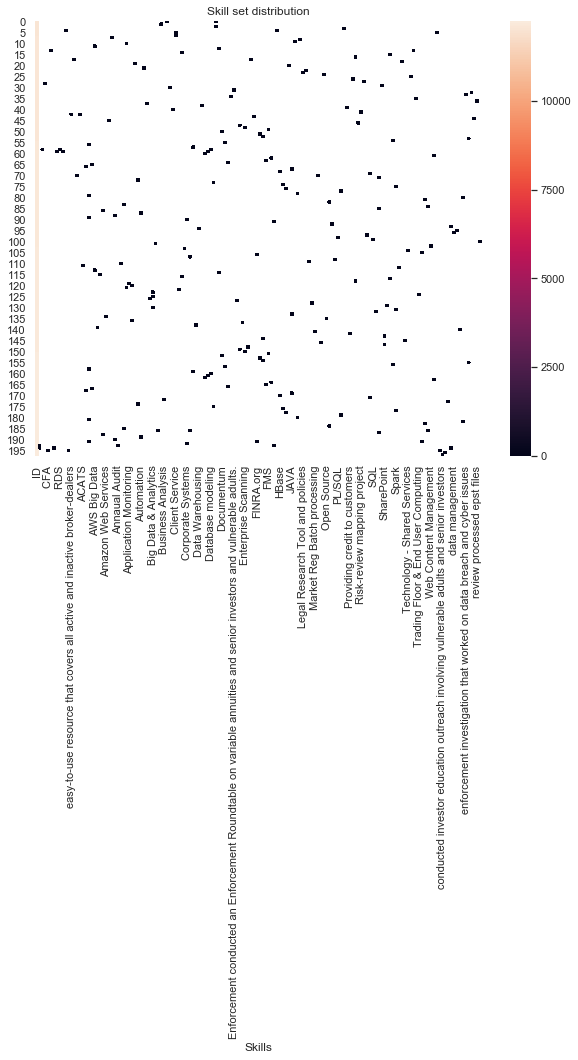

In [633]:
ax1 = plt.axes()
sns.heatmap(emplyeeSkillsMatrix, ax = ax1)
ax1.set_title('Skill set distribution')

In [634]:
# massage empolyee project data
projectData = pd.melt(employee[['ID','PastProjectsID']].set_index('ID')['PastProjectsID'].str.split(";", n = -1, expand = True).reset_index(),
              id_vars = ['ID'],
              value_name = 'PastProjectsID')\
        .dropna().drop(['variable'], axis = 1)\
        .groupby(['ID','PastProjectsID']).agg({'PastProjectsID':"count"})\
        .rename(columns={'PastProjectsID':'PastProjectsCount'}).reset_index()
projectData['PastProjectsCount'] = projectData['PastProjectsCount'].astype(np.int64)
projectDataMatrix = pd.pivot_table(projectData, values = 'PastProjectsCount', 
                          index = 'ID', columns = 'PastProjectsID').reset_index()
projectDataMatrixNoNan = projectDataMatrix.fillna(0)
projectDataMatrixNoNan.head()


PastProjectsID,ID,,1,10,100,101,102,103,104,105,...,90,91,92,93,94,95,96,97,98,99
0,12056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'Project participation distribution')

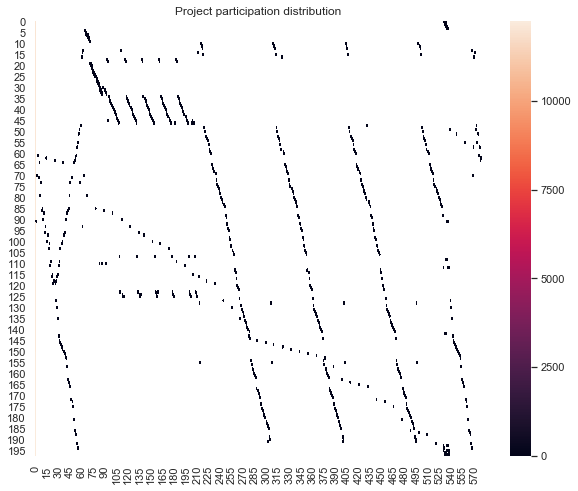

In [635]:
ax1 = plt.axes()
sns.heatmap(projectDataMatrix.values)
ax1.set_title('Project participation distribution')

In [636]:
# Join all the information for employe processed table
list_df = [employeeBaseInf,emplyeeCatFeaturesWithoutSkillsProjects,emplyeeSkillsdataNoNan,projectDataMatrixNoNan ]
employeeReady = reduce(lambda left, right: pd.merge(left, right, on = ['ID'], how = 'inner'), list_df)
employeeReady.shape
employeeReady.head()

,ID,FirstName,LastName,profilePictrueName,YeasInCompany,Hobbies_Bike,Hobbies_Hiking,Hobbies_Reading,Hobbies_Swimming,Hobbies_Travel,...,90,91,92,93,94,95,96,97,98,99
0,12126,Brant,Crichlow,BrantCrichlow,2,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12069,John,Chevez,JohnChevez,3,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12070,Justin,Kapadia,JustinKapadia,3,0,0,0,0,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12072,Douglas,Giarratano,DouglasGiarratano,3,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12103,Gerald,Otto,GeraldOtto,7,0,0,1,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [637]:
employeeNumericOnly = employeeReady.iloc[:,4:] # selection only numeric data
employeeNumericOnly.head()

,YeasInCompany,Hobbies_Bike,Hobbies_Hiking,Hobbies_Reading,Hobbies_Swimming,Hobbies_Travel,Hobbies_Volleyball,Hub_Exam,Hub_Fiancial,Hub_Finacial,...,90,91,92,93,94,95,96,97,98,99
0,2,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,0,0,0,1,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0,0,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'Employee process numerical features')

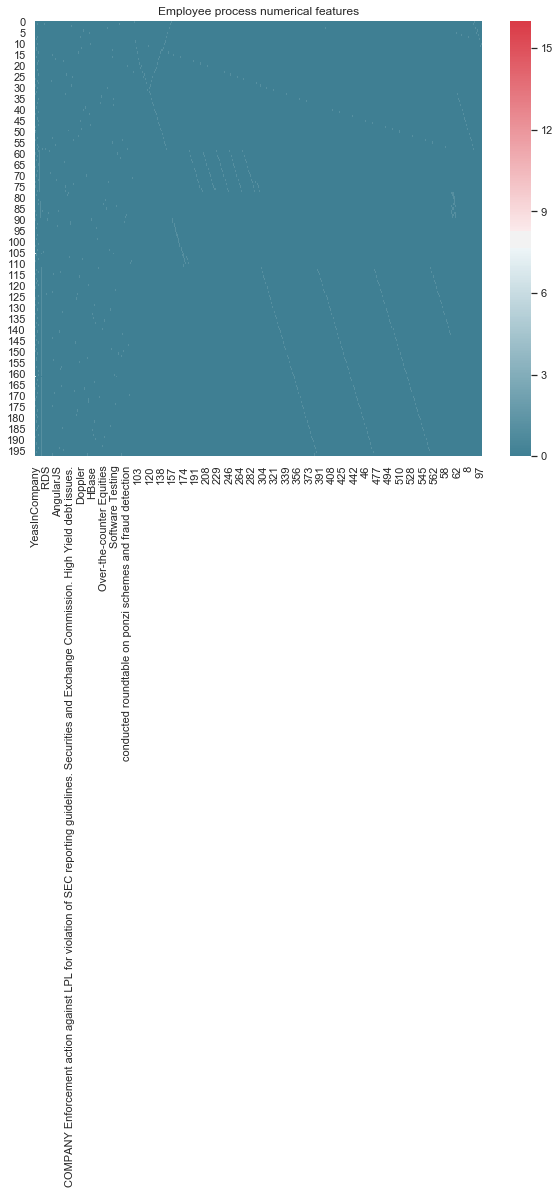

In [638]:
ax1 = plt.axes()
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(employeeNumericOnly,cmap = cmap, ax = ax1)
ax1.set_title('Employee process numerical features')

Text(0.5, 1.0, 'Employee similarity matrix')

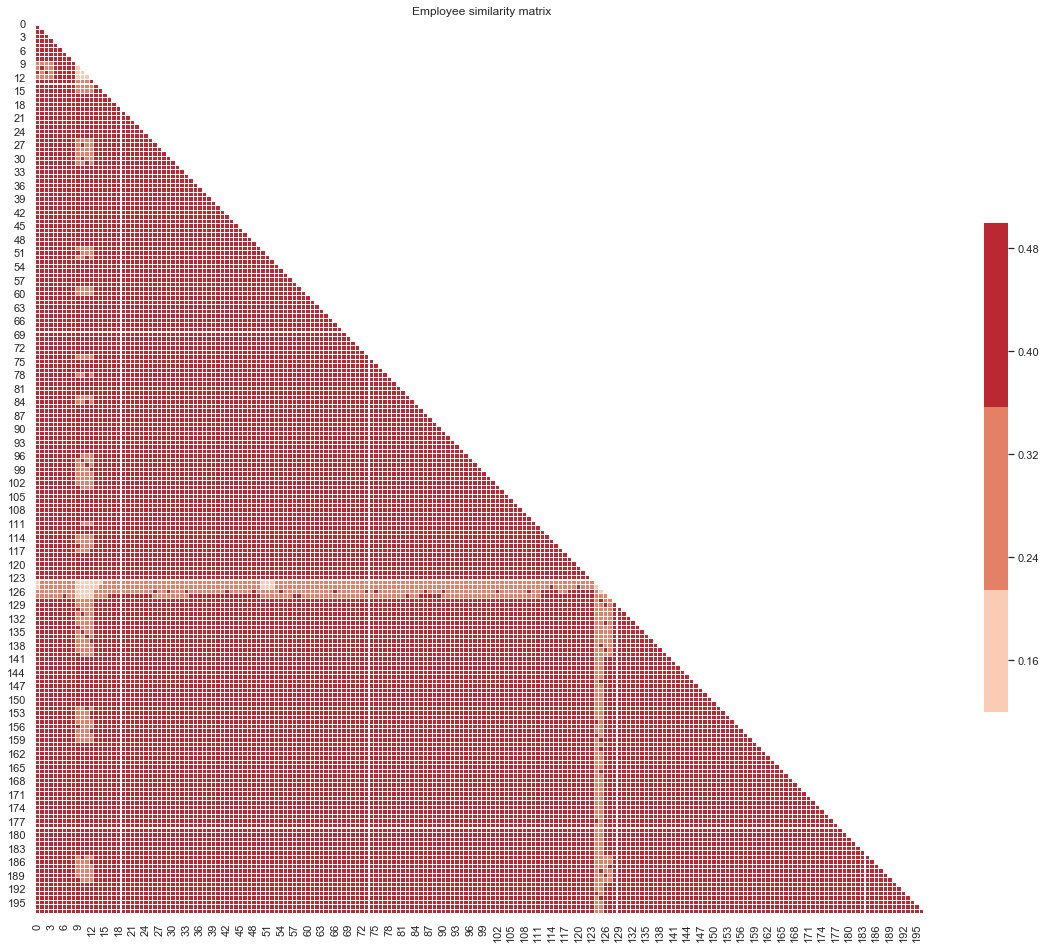

In [639]:
corr = np.corrcoef(employeeNumericOnly)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20, 18))
cmap = sns.color_palette("RdBu_r", 7)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,cmap = cmap,  vmax=.5, center=0,
            square=True, linewidths=0.01, cbar_kws={"shrink": .5})
ax.set_title('Employee similarity matrix')

In [640]:
# save matrix
employeeSimilarityDF = pd.DataFrame(corr, index=employee.ID)
employeeSimilarityDF.columns = list(employee.ID)
employeeSimilarityDF.to_csv('employee_similarity_matrix.csv')
employeeSimilarityDF.head()


,12126,12069,12070,12072,12103,12105,12107,12111,12113,12117,...,12234,12235,12236,12238,12239,12240,12241,12245,12246,12247
ID,,,,,,,,,,,,,,,,,,,,,
12126,1.000000,0.485849,0.588679,0.523210,0.600573,0.643870,0.606525,0.600573,0.600573,0.251970,...,0.394794,0.394794,0.394794,0.632216,0.583097,0.590509,0.583097,0.632216,0.583097,0.613191
12069,0.485849,1.000000,0.618526,0.642398,0.736760,0.736760,0.743917,0.772088,0.736760,0.310959,...,0.485849,0.485849,0.485849,0.715600,0.715600,0.724532,0.715600,0.715600,0.715600,0.752160
12070,0.588679,0.618526,1.000000,0.665274,0.762781,0.799328,0.770141,0.762781,0.762781,0.322579,...,0.503535,0.503535,0.503535,0.782432,0.740970,0.750162,0.740970,0.782432,0.740970,0.778697
12072,0.523210,0.642398,0.665274,1.000000,0.791757,0.791757,0.799345,0.791757,0.791757,0.335494,...,0.523210,0.523210,0.523210,0.769218,0.769218,0.778701,0.769218,0.769218,0.769218,0.808250
12103,0.600573,0.736760,0.762781,0.791757,1.000000,0.907074,0.915657,0.907074,0.907074,0.441641,...,0.600573,0.600573,0.643870,0.881464,0.881464,0.892205,0.881464,0.881464,0.881464,0.925908


In [641]:
temp = pd.read_csv('employee_similarity_matrix.csv',index_col = 'ID')
temp.index = temp.index.map(str)
# score = temp.loc['12057',:]
# score

# 2. Return top K similar users
* Input: User ID, User Similarity Matrix
* Output: Top K user from high to low

In [642]:
"""
This function returns a list of employe ID (string) with highest similarity to lowest
"""
def findTopKSimilarEmployee(eId, topK = 'all', eSimilarityMatrixFile='employee_similarity_matrix.csv'):
    import pandas as pd
    import numpy as np
    matrix = pd.read_csv(eSimilarityMatrixFile, index_col = 'ID')
    matrix.index = matrix.index.map(str)
    # retrieve ranked employ based on e-e similarity
    sim = matrix.loc[str(eId),:]
    sortedSim = sim.sort_values(ascending=False)
    # return a list of employee id from high to low 
    eIdSorted = sortedSim.iloc[1:].index.tolist()
    if(topK == 'all'):
        return eIdSorted
    else:
        return eIdSorted[0:topK]

In [643]:
# test
print("The top 5 similar employee for employee %d is: %s"%(5, '|'.join(findTopKSimilarEmployee('12250',5))))

KeyError: '12250'

# 3. Traning - team builder
This will create a project embedding matrix for all existing projects and take an project text input and returns the top K similar projects. <\br>

*. 1st, create project embedding and save the embedding object for predcit

*. 2nd, create project similarity matrix for later recommendation

In [644]:
project = pd.read_csv('../data/Projects_M23.txt',sep = '|')
projectCategory = pd.read_csv('../data/Project_category_M23.txt',sep = '|')
print(project.shape)
project.head()

(594, 6)


,pID,ProjectName,ProjectTeam,ProjectOwner,ProjectDescription,ProjectCategoryId
0,1,Planning,"Jessica Burns,TIMOTHY Murphy,Steven Canedy,Ger...",Alesha Pasternak,"Workforce and Financial planning, reporting an...",1
1,2,slutions meeting,"TIMOTHY Murphy,Steven Canedy,Gerald SIDOTI,MIK...",Sung Mijangos,"Tax, Payment and Compliance Solution meeting",1
2,3,Travel planning,"Steven Canedy,Gerald SIDOTI,MIKE Cohen,Brooks ...",Phyliss Barrette,Travel Management is a provider of travel man...,1
3,4,Risk monitoring,"Gerald SIDOTI,MIKE Cohen,Brooks Santangelo,Rob...",Suk Bunn,firm review using analytics workspace,1
4,5,Registration,"MIKE Cohen,Brooks Santangelo,Robert Delise,Vil...",Eliz Dewall,reporting of registration statistics,1


Text(0.5, 1.0, 'Project distribution by category')

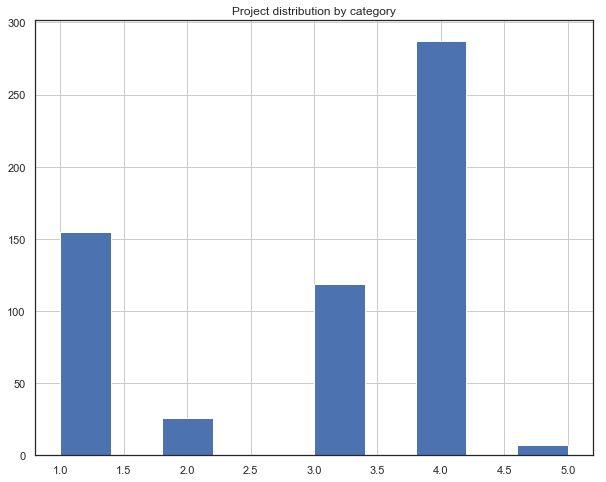

In [645]:
# plot project per category distribution
project['ProjectCategoryId'].hist()
plt.title('Project distribution by category')

In [646]:
def preprocess(text):
    # remove non-alphabetic characters
    textAlphabetic = re.sub('[^A-Za-z]', ' ', text)
    # make all words lower case
    textLower = textAlphabetic.lower()
    # remove stop words
    tokenized_text = word_tokenize(textLower)
    for word in tokenized_text:
        if word in stopwords.words('english'):
            tokenized_text.remove(word)
    # stemming
    stemmer = PorterStemmer()
    for i in range(len(tokenized_text)):
        tokenized_text[i] = stemmer.stem(spell(tokenized_text[i]))

    return tokenized_text

def stem_tokenize(text):
    return [stemmer(i) for i in word_tokenize(text)]


In [647]:
def dataPreparation(data,textCol = 'ProjectDescription', vectMethod = 'countVectorizer'):
    if vectMethod == "countVectorizer":
        vectorizer = CountVectorizer(analyzer=preprocess, min_df = 2, max_df= 0.8)
        vectorizerFile = 'countVectorizer.pkl'
    elif vectMethod == "tfidf":
        vectorizer = TfidfVectorizer(ngram_range=(0,2),analyzer='word',
                               lowercase=True, token_pattern='[a-zA-Z0-9]+',
                               strip_accents='unicode',tokenizer=stem_tokenize)
        vectorizerFile = 'tfidfVectorizer.pkl'
    else:
        raise ValueError("Not accepted tokenizer.")
        
    # start to transform data and save vectorizer for predict
    
    X = vectorizer.fit_transform(data[textCol]).toarray()
    with open(vectorizerFile, 'wb') as fin:
        pickle.dump(vectorizer, fin)
    
    labels = list(set(data.iloc[:,-1])) # the target feature is the last column
    le = preprocessing.LabelEncoder()
    le.fit(labels)
    y = le.fit_transform(project.iloc[:, -1])
    return X,y

In [648]:
def train(X,y, model = 'NaiveBayes'):
    from sklearn.model_selection import train_test_split
    from sklearn.multiclass import OneVsRestClassifier
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.svm import SVC
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True)
    if model == 'NaiveBayes':
        model = OneVsRestClassifier(MultinomialNB(fit_prior = True, class_prior = None))
    elif model == 'SVC':
        model = LinearSVC()
    elif model == 'LogisticRegress':
        model = LogisticRegression(solver='sag')
    for category in categories:
        print(".. Processing category: {}: {} -- ".format(category,projectCatDict[category]))
        # train model using the x_dtm & y
        model.fit(X_train, (y_train == category).astype('int'))
        prediction = model.predict(X_test)
        print("Test accuracy is {}".format(accuracy_score((y_test == category).astype('int'), prediction)))
    return model

In [649]:
X, y = dataPreparation(project)
categories = set(project['ProjectCategoryId'])

In [650]:
projectCatDict = dict(zip(projectCategory['id'], projectCategory['ProjectCategory']))

In [651]:
train(X,y)

.. Processing category: 1: Business -- 
Test accuracy is 0.959731543624161
.. Processing category: 2: Legal -- 
Test accuracy is 0.8993288590604027
.. Processing category: 3: Exam -- 
Test accuracy is 0.7718120805369127
.. Processing category: 4: Technology -- 
Test accuracy is 0.9798657718120806
.. Processing category: 5: Finacial -- 
Test accuracy is 1.0


/Users/liangkuang/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))


OneVsRestClassifier(estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
          n_jobs=None)

In [652]:
# save embedded project matrix to disk
embeddedProjectDF = pd.DataFrame(X, index = project['pID'])
embeddedProjectDF.to_csv("embeddedProject.csv")

In [653]:
a = pd.read_csv('embeddedProject.csv',index_col = 'pID')
a.head()

,0,1,2,3,4,5,6,7,8,9,...,489,490,491,492,493,494,495,496,497,498
pID,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 3.2 Project similarity

In [654]:
# save matrix
corrProject = np.corrcoef(embeddedProjectDF)
projectSimilarityDF = pd.DataFrame(corrProject, index=project.pID)
projectSimilarityDF.columns = list(project.pID)
projectSimilarityDF.to_csv('project_similarity_matrix.csv')
projectSimilarityDF.head()

/Users/liangkuang/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/liangkuang/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


,1,2,3,4,5,6,7,8,9,10,...,585,586,587,588,589,590,591,592,593,594
pID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,-0.009044,-0.010221,-0.009044,0.283723,-0.008081,0.126145,-0.009044,-0.011001,-0.009917,...,-0.006991,-0.006991,-0.008081,-0.006991,-0.004028,-0.004028,0.495336,-0.009917,-0.010246,0.149533
2,-0.009044,1.000000,0.092341,-0.010121,-0.007824,-0.009044,-0.009674,-0.010121,0.260751,-0.011099,...,-0.007824,-0.007824,-0.009044,-0.007824,-0.004508,-0.004508,-0.010566,-0.011099,-0.011467,-0.011467
3,-0.010221,0.092341,1.000000,-0.011439,-0.008842,0.221604,-0.010933,-0.011439,-0.013915,-0.012543,...,-0.008842,0.258576,0.221604,-0.008842,-0.005095,-0.005095,-0.011942,-0.012543,-0.012960,-0.012960
4,-0.009044,-0.010121,-0.011439,1.000000,-0.007824,-0.009044,-0.009674,-0.010121,0.124219,-0.011099,...,-0.007824,-0.007824,-0.009044,-0.007824,-0.004508,-0.004508,0.140081,-0.011099,-0.011467,0.417699
5,0.283723,-0.007824,-0.008842,-0.007824,1.000000,-0.006991,0.148005,-0.007824,-0.009518,-0.008580,...,-0.006048,-0.006048,-0.006991,-0.006048,-0.003485,-0.003485,-0.008168,-0.008580,-0.008865,0.175447


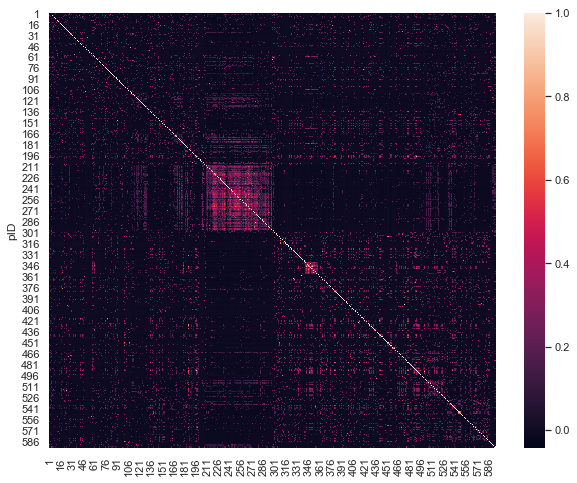

In [655]:
sns.heatmap(projectSimilarityDF)

# 3.3 production
* 1. Return top K similar project from existing projects table

In [656]:
"""
This function returns a list of employe ID (string) with highest similarity to lowest
"""
def findTopKSimilarProject(eId, topK = 'all', eSimilarityMatrixFile='project_similarity_matrix.csv'):
    import pandas as pd
    import numpy as np
    matrix = pd.read_csv(eSimilarityMatrixFile, index_col = 'pID')
    matrix.index = matrix.index.map(str)
    # retrieve ranked employ based on e-e similarity
    sim = matrix.loc[str(eId),:]
    sortedSim = sim.sort_values(ascending=False)
    # return a list of employee id from high to low 
    pIdSorted = sortedSim.iloc[1:].index.tolist()
    if(topK == 'all'):
        return pIdSorted
    else:
        return pIdSorted[0:topK]

In [657]:
print("The top 5 similar projects for project %d is: %s"%(5, '|'.join(findTopKSimilarProject('2',5))))

The top 5 similar projects for project 5 is: 95|9|509|361|48


In [658]:
def predictTopKProject(text, topK = 5, vectorizer = 'countVectorizer.pkl',
            embeddedProject = 'embeddedProject.csv',
            employeeSimMatrix = 'employee_similarity_matrix.csv',
           projectSimMatrix = 'project_similarity_matrix.csv'):
    from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
    # load project embedding
    embeddedProject = pd.read_csv('embeddedProject.csv',index_col = 'pID')
    # preprocess
    text_preprocessed = preprocess(text)
    with open(vectorizer, 'rb') as f1:
        vectorizer = pickle.load(f1)
    
    text_vectorized = vectorizer.transform([text]).toarray()
    score = []
    for i in range(embeddedProject.shape[0]):
        prior_project = embeddedProject.iloc[i,:]
        score.append(np.corrcoef(text_vectorized, prior_project)[0][1])
    mylist = sorted(enumerate(score), key=lambda x: -x[1])
    idx = [l[0] for l in mylist]
    score_sorted = [l[1] for l in mylist]
    pIds = [embeddedProject.index[ii] for ii in idx]
    if topK == 'all':
        return pIds
    else:
        return pIds[0:topK]

def cosine_similarity_one_vs_array(vector,matrix):
    return ( np.sum(vector*matrix,axis=1) / 
            ( np.sqrt(np.sum(matrix**2,axis=1)) * np.sqrt(np.sum(vector**2)) ) )[::-1]

In [659]:
a = project['ProjectDescription'][1]
a

'Tax, Payment and Compliance Solution meeting'

In [660]:
b = predictTopKProject(a)

In [661]:
b

[2, 95, 9, 48, 28]

* 2. Return a list of employee ID given a project description

Based on top K similar project, get all employee ID worked on these project, return top K employee. For each category, return at lease one employee.

* 1. grab all employee worked on top K project
* 2. for each category, find top K employees
* 3. If not enough, tap into employee similarity matrix and retrieve other similar employees to the top 1. Exclude already picked one.


In [662]:
"""
input: a List of pIds
Return employee ID list given a project ID: string
Return a list.
"""
def getEmployeeIDForPid(pId, projectTablePath = r'../data/Projects_M23.txt'):
    if len(pId) == 0:
        return None
    project = pd.read_csv(projectTablePath,sep = '|', index_col = 'pID')
    project.index = project.index.map(str)
    eNames = []
    for ids in pId:
        eNames = eNames + project.loc[ids,:]['ProjectTeam'].split(',')
    # load name 2 ID dictionary if it's name, remove this with new data using eId in project data
    with open('employeNameIDDict.pkl','rb') as fin:
        name2idDict = pickle.load(fin)
    print(eNames)
    eIds = [name2idDict[name] for name in eNames]
    return list(eIds)

In [663]:
eids = getEmployeeIDForPid(['1','2'])
print(eids)

['Jessica Burns', 'TIMOTHY Murphy', 'Steven Canedy', 'Gerald SIDOTI', 'TIMOTHY Murphy', 'Steven Canedy', 'Gerald SIDOTI', 'MIKE Cohen']
[12057, 12058, 12059, 12060, 12058, 12059, 12060, 12061]


In [664]:
# get the hub
ehubs = [str(employee.loc[employee['ID'] == ids,:]['Hub'].values) for ids in eids]
ehubs

["['Fiancial']",
 "['Fiancial']",
 "['Fiancial']",
 "['Legal']",
 "['Fiancial']",
 "['Fiancial']",
 "['Legal']",
 "['Legal']"]

* 3. logic to get the top K employee for each hub

    Hub is also matched to project category. employee similarity table will be used. The logic here is to: scan through all the employees and get the first couple employee at teach hub, if not enough then tap into employee similarity table to get the rest.